In [1]:
# for loading google drive files
from google.colab import drive
drive.mount('/content/drive')

# for data cleaning
import pandas as pd
import numpy as np

# for tokenizing english words and applying GloVe representation
import spacy
!python -m spacy download en_core_web_sm
import gensim
from gensim import corpora, models
# for improving plural to singular lemmatization
import inflect
p = inflect.engine()

# for visualizing frequency in order
import operator
import matplotlib.pyplot as plt

# for measuring training time 
import time

# for logging LDA model convergence
#import logging
#logging.basicConfig(format='%(message)s', level=logging.INFO)
from IPython.display import clear_output

# for sampling topics from the LDA model
import random

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:
# flags
XLSX_PATH = '/content/drive/My Drive/Colab Notebooks/Project_REScipe/data/total_data.xlsx'      # copy the path of the xlsx file in Path in Google Colab menu
XLSX_COLUMN = ['rand_int_0', 'name', 'url', 'rand_int_1', 'size', 'ingredient', 'recipe', 'url_ext']

===================== A =====================

This section loads the excel file(.xlsx) into a Pandas Dataframe.

（if total_name.csv already exists, do not run this section）


In [ ]:
# load the xlsx file from Google Drive to a Pandas Dataframe
xlsx_total_data = pd.read_excel(XLSX_PATH, header=None, names=XLSX_COLUMN)

print(xlsx_total_data)

       rand_int_0  ... url_ext
0               0  ...   70006
1               1  ...   70012
2               2  ...   70014
3               3  ...   70019
4               4  ...   70032
...           ...  ...     ...
46899          21  ...  269894
46900          22  ...  269895
46901          23  ...  269896
46902          24  ...  269898
46903          25  ...  269899

[46904 rows x 8 columns]


===================== B =====================

This section saves recipe names (index 'name') from the Pandas Dataframe to a csv file in the same Google Drive folder.

This file (total_name.csv) is a look-up dictionary for debugging topic modeling and LDA.

（if total_name.csv already exists, do not run this section）

In [ ]:
# extract the column of 'name' from the Pandas Dataframe
csv_name = xlsx_total_data[['name']]
# add an additional index column, in case that tokenization or GloVe representation removes certain recipes
csv_name['index'] = xlsx_total_data[['url_ext']]

csv_path = '/'.join(XLSX_PATH.split(sep='/')[:-1]) + '/total_name.csv'
csv_name.to_csv(csv_path, index=False)

print(csv_name)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


                                       name   index
0                    Whole Wheat Pita Bread   70006
1              Baked Mac and Cheese for One   70012
2                             Blonde Bobbie   70014
3                                Egg Butter   70019
4                                Beer Pizza   70032
...                                     ...     ...
46899                     Love Potion No. 9  269894
46900      Pimiento Cheese and Tomato Bites  269895
46901  Wolfgang Puck's Cheeseburger Sliders  269896
46902    Instant PotÂ® Sweet Baby Back Ribs  269898
46903           Instant PotÂ® Zuppa Toscana  269899

[46904 rows x 2 columns]


===================== C =====================

This section loads total_name.csv and saves a tokenized version of this csv back.

This file (token_name.csv) is used for topic modeling with LDA, and GloVe representation (optional).

（if token_name.csv already exists, do not run this section. This section will take approximately 15 minutes to run.）

In [ ]:
csv_path = '/'.join(XLSX_PATH.split(sep='/')[:-1]) + '/total_name.csv'
csv_name = pd.read_csv(csv_path)

# load spaCy english nlp model
nlp = spacy.load('en_core_web_sm')

# tokenize, remove non-ascii chars, lemmatize, remove stop words (safe actions)
list_token_name = []
for i, row in csv_name.iterrows():
  token_name = []
  # tokenize and lemmatize
  for word in nlp(row['name']):
    # remove non-ascii chars
    if all(ord(char) < 128 for char in word.lemma_):
      text = word.text
      lemma = word.lemma_.lower()
    else:
      text = word.text.encode('ascii','ignore').decode()
      lemma = word.lemma_.lower().encode('ascii','ignore').decode()
    # remove stop words
    if (len(text) > 2) and (len(lemma) > 2) and (word.is_stop == False):
      if p.singular_noun(lemma) != False:
        token_name.append(p.singular_noun(lemma))
      else:
        token_name.append(lemma)
  if token_name != []:
    list_token_name.append([token_name, row['index']])
  else:
    print(row['index'], row['name'],'removed by tokenization.', sep='\t')
  if i % 1000 == 0:
    print('Tokenizing:', i, '~', min(i+1000, csv_name.shape[0]))

csv_token_name = pd.DataFrame(list_token_name, columns=['token_name', 'index'])
print(csv_token_name)

csv_path = '/'.join(XLSX_PATH.split(sep='/')[:-1]) + '/token_name.csv'
csv_token_name.to_csv(csv_path, index=False)

Tokenizing: 0 ~ 1000
Tokenizing: 1000 ~ 2000
Tokenizing: 2000 ~ 3000
Tokenizing: 3000 ~ 4000
Tokenizing: 4000 ~ 5000
Tokenizing: 5000 ~ 6000
Tokenizing: 6000 ~ 7000
105842	CB	removed by tokenization.
Tokenizing: 7000 ~ 8000
Tokenizing: 8000 ~ 9000
Tokenizing: 9000 ~ 10000
Tokenizing: 10000 ~ 11000
Tokenizing: 11000 ~ 12000
Tokenizing: 12000 ~ 13000
Tokenizing: 13000 ~ 14000
Tokenizing: 14000 ~ 15000
Tokenizing: 15000 ~ 16000
Tokenizing: 16000 ~ 17000
Tokenizing: 17000 ~ 18000
Tokenizing: 18000 ~ 19000
Tokenizing: 19000 ~ 20000
Tokenizing: 20000 ~ 21000
Tokenizing: 21000 ~ 22000
Tokenizing: 22000 ~ 23000
Tokenizing: 23000 ~ 24000
Tokenizing: 24000 ~ 25000
Tokenizing: 25000 ~ 26000
Tokenizing: 26000 ~ 27000
229194	7 and 7	removed by tokenization.
229196	7 and 7 and 7	removed by tokenization.
Tokenizing: 27000 ~ 28000
Tokenizing: 28000 ~ 29000
Tokenizing: 29000 ~ 30000
Tokenizing: 30000 ~ 31000
Tokenizing: 31000 ~ 32000
Tokenizing: 32000 ~ 33000
Tokenizing: 33000 ~ 34000
Tokenizing: 34000

Reading and copying: 0 ~ 10000
Reading and copying: 10000 ~ 20000
Reading and copying: 20000 ~ 30000
Reading and copying: 30000 ~ 40000
Reading and copying: 40000 ~ 46900
# of Recipe:	 46901
# of Word:	 174223
unique Tokens:	 8811

infrequent Tokens:	 4455
Removing infrequent tokens: 0 ~ 1000
!	70105	['channel', 'marker']	removed due to lack of common tokens.
!	70329	['hamantashen']	removed due to lack of common tokens.
!	70753	['mangu']	removed due to lack of common tokens.
!	70766	['karithopita']	removed due to lack of common tokens.
!	70778	['dolma']	removed due to lack of common tokens.
!	71010	['tako', 'poki']	removed due to lack of common tokens.
!	72052	['finadeni']	removed due to lack of common tokens.
!	72460	['ghoraiybah']	removed due to lack of common tokens.
!	72483	['biriyani']	removed due to lack of common tokens.
!	72814	['turffaloaf']	removed due to lack of common tokens.
!	73422	['borboleta']	removed due to lack of common tokens.
!	73952	['cranachan']	removed due to la

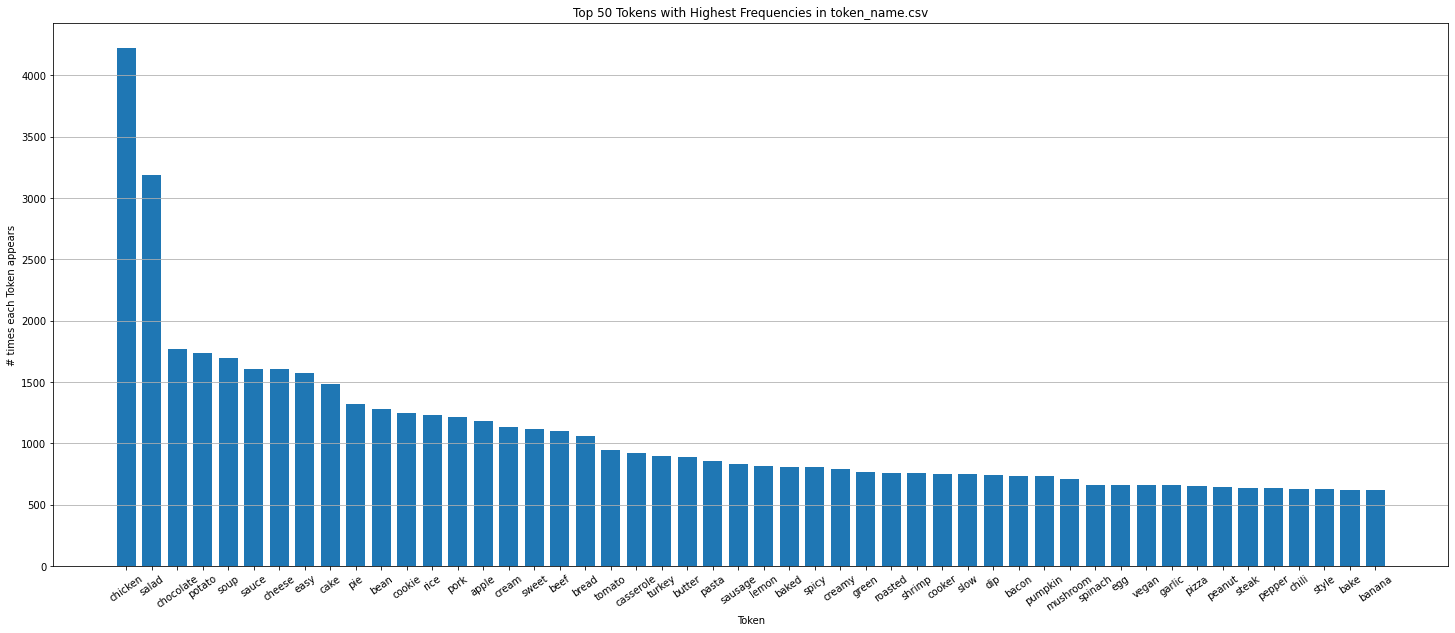

In [ ]:
csv_path = '/'.join(XLSX_PATH.split(sep='/')[:-1]) + '/token_name.csv'
csv_token_name = pd.read_csv(csv_path)

# count number of (1)recipe, (2)unique token, (3)token/word
# list_remain_name is a list copy of csv_token_name, and will be filtered.
dict_token = {}
count_token = 0
list_remain_name = []
for i, row in csv_token_name.iterrows():
  remain_name = []
  for word in row['token_name'].strip("[]").split(', '):
    word = word[1:-1]
    if (word in dict_token):
      dict_token[word] += 1
    else:
      dict_token[word] = 1
    count_token += 1
    remain_name.append(word)
  list_remain_name.append([remain_name, row['index']])
  if i % 10000 == 0:
    print('Reading and copying:', i, '~', min(i+10000, csv_token_name.shape[0]-1))
print('# of Recipe:\t', len(list_remain_name))
print('# of Word:\t', count_token)
print('unique Tokens:\t', len(dict_token), end='\n\n')

# visualize top 50 tokens with highest frequencies
dict_top_token = dict(sorted(dict_token.items(), key=operator.itemgetter(1), reverse=True)[:50])
f0 = plt.figure(num=0, figsize=(25,10))
f0.patch.set_facecolor('white')
plt.bar(dict_top_token.keys(), dict_top_token.values(), width=0.75)
plt.xticks(rotation=35)
plt.grid(axis='y')
plt.xlabel('Token')
plt.ylabel('# times each Token appears')
plt.title('Top 50 Tokens with Highest Frequencies in token_name.csv')
f0.show()

# remove infrequent tokens that appear only 1 time in token_name.csv
# (if the tokenized name of a recipe is empty, the recipe will be removed)
list_infreq_token = [key for (key,value) in dict_token.items() if value<=1]
print('infrequent Tokens:\t', len(list_infreq_token))
count_token = 0                               # number of words remaining
count_removed_token = 0                       # number of words removed
                                          ### (sum to original # words)
count_removed = 0                             # number of rows removed
                                          ### (sum to original recipe)
list_token = []                               # dictionary of remaining tokens
                                          ### (sum to )
original_length = len(list_remain_name)
# for each recipe
i = 0
index = 0
while i < len(list_remain_name):
  # report every 1000 iterative steps
  if index % 1000 == 0:
    print('Removing infrequent tokens:', index, '~', min(index+1000, original_length-1))
  row = list_remain_name[i]
  name_list = row[0]
  name_keeper = name_list.copy()
  # for each word in a recipe
  for token in name_keeper:
    if token in list_infreq_token:
      count_removed_token += 1
      name_list.remove(token)
    else:
      count_token += 1
      if token not in list_token:
        list_token.append(token)
  i += 1
  index += 1
  # after looping through all words in a recipe
  if name_list == []:
    count_removed += 1
    print('!', row[1], name_keeper,'removed due to lack of common tokens.', sep='\t')
    list_remain_name.remove(row)
    i = i - 1
  #elif len(name_keeper) - 1 > len(name_list):
    #print(' ', row[1], name_keeper, '-->', name_list, sep='\t')   # print recipe that loses at least 2 tokens

print('# of Recipe:\t', len(list_remain_name), '(-' + str(count_removed) + ')')
print('# of Word:\t', count_token, '(-' + str(count_removed_token) + ')')
print('unique Tokens:\t', len(list_token), '(-' + str(len(dict_token)-len(list_token)) + ')', end='\n\n')

csv_filtered_token = pd.DataFrame(list_remain_name, columns=['filtered_token', 'index'])
print(csv_filtered_token)

csv_path = '/'.join(XLSX_PATH.split(sep='/')[:-1]) + '/filtered_token.csv'
csv_filtered_token.to_csv(csv_path, index=False)

===================== D =====================

This section loads filtered_token.csv and saves 2 files (or optionally 2 pairs of 2 files):

(1) lda_tfidf.model (or optionally lda_glove.model), a Latent Dirichlet Allocation (LDA) model file

(2) topic_tfidf.csv (or optionally topic_glove.csv), a csv with 2 columns: topic_name, and index

The file(s) topic_tfidf.csv or(and) topic_glove.csv will be used as label look-up.

In [3]:
csv_path = '/'.join(XLSX_PATH.split(sep='/')[:-1]) + '/filtered_token.csv'
csv_filtered_token = pd.read_csv(csv_path)

# count_token and list_token are used to debug gensim topic modeling and dictionary
list_filtered_token = []
list_single_filtered_token = []
count_token = 0
list_unique_token = []
for i, row in csv_filtered_token.iterrows():
  if i % 10000 == 0:
    print('Reading and copying:', i, '~', min(i+10000, csv_filtered_token.shape[0]-1))
  filtered_token = []
  row_extract = row['filtered_token'].strip("[]").split(', ')
###################################################################################
                                                                                  # DOES NOT LOAD SINGLE_WORD RECIPE WITH REPEATED NAME
  if len(row_extract) == 1:
    token = (row_extract[0])[1:-1]
    if token in list_unique_token:
      continue
    else:
      if [[token], row['index']] in list_single_filtered_token:
        continue
      else:
        list_single_filtered_token.append([[token], row['index']])
        continue
###################################################################################
  for token in row_extract:
    count_token += 1
    token = token[1:-1]
    if token not in list_unique_token:
      list_unique_token.append(token)
    filtered_token.append(token)
  list_filtered_token.append([filtered_token, row['index']])
###################################################################################
                                                                                  # DOES NOT LOAD SINGLE_WORD RECIPE WITH REPEATED NAME
for row in list_single_filtered_token:
  if row[0][0] not in list_unique_token:
    count_token += 1
    list_unique_token.append(row[0][0])
    list_filtered_token.append(row)
###################################################################################

print('# of Recipe:\t', len(list_filtered_token))
print('# of Word:\t', count_token)
print('unique Tokens:\t', len(list_unique_token))

Reading and copying: 0 ~ 10000
Reading and copying: 10000 ~ 20000
Reading and copying: 20000 ~ 30000
Reading and copying: 30000 ~ 40000
Reading and copying: 40000 ~ 46658
# of Recipe:	 45725
# of Word:	 168834
unique Tokens:	 4356


In [4]:
# number of sample to show
n_sample = 11

# isolate 'filtered_token' column from list_filtered_token
list_only_token = []
for row in list_filtered_token:
  list_only_token.append(row[0])
for i in range(n_sample):
  print('\t', list_only_token[len(list_filtered_token)-1-i])
print('\t', '...', end='\n\n')

# create a gensim dictionary
id_to_token = corpora.Dictionary(list_only_token)
print('gensim dictionary tokens:\t', len(id_to_token))
for i in range(n_sample):
  print('\t', i, id_to_token[i])
print('\t', '...', end='\n\n')

# create bag-of-words (BoW) representation 
corpus_bow = [id_to_token.doc2bow(token) for token in list_only_token]
print('gensim BoW recipe:\t', len(corpus_bow))
for i in range(n_sample):
  print('\t', corpus_bow[i])
print('\t', '...', end='\n\n')

# create TF-IDF representation using bag-of-words representation
tfidf = models.TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]
print('gensim TF-IDF recipe:\t', len(corpus_tfidf))
for i in range(n_sample):
  print('\t', corpus_tfidf[i])
print('\t', '...')

	 ['bordeaux']
	 ['salpicon']
	 ['tiropita']
	 ['suspiro']
	 ['stroopwafel']
	 ['instant', 'pot', 'zuppa', 'toscana']
	 ['instant', 'pot', 'sweet', 'baby', 'rib']
	 ['puck', 'cheeseburger', 'slider']
	 ['pimiento', 'cheese', 'tomato', 'bite']
	 ['love', 'potion']
	 ['king', 'cake', 'cupcake']
	 ...

gensim dictionary tokens:	 4356
	 0 bread
	 1 pita
	 2 wheat
	 3 baked
	 4 cheese
	 5 mac
	 6 blonde
	 7 bobbie
	 8 butter
	 9 egg
	 10 beer
	 ...

gensim BoW recipe:	 45725
	 [(0, 1), (1, 1), (2, 1)]
	 [(3, 1), (4, 1), (5, 1)]
	 [(6, 1), (7, 1)]
	 [(8, 1), (9, 1)]
	 [(10, 1), (11, 1)]
	 [(12, 1), (13, 1), (14, 1)]
	 [(15, 1), (16, 1)]
	 [(10, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1)]
	 [(22, 1), (23, 1), (24, 1), (25, 1), (26, 1)]
	 [(27, 1), (28, 1), (29, 1)]
	 [(30, 1), (31, 1), (32, 1), (33, 1)]
	 ...

gensim TF-IDF recipe:	 45725
	 [(0, 0.40334788355705303), (1, 0.6965942062984433), (2, 0.5933523376388499)]
	 [(3, 0.517495204907533), (4, 0.4300581543969523), (5, 0.73976259484675

In [ ]:
# training hyperparameters
num_topics = 300                                    # based on general categorization of allrecipes.com
chunk_num = 32                                      # based on number of CPU cores
chunksize = len(list_filtered_token) // chunk_num + 1
passes = 16
iterations = 10 ** 9

print('LDA Training Hyperparameters:')
print('', '# Topic:', num_topics, sep='\t')
print('', 'Chunksize:', chunksize, sep='\t')
print('', '# Pass(corpus):', passes, sep='\t')
print('', '# Iteration:', iterations, sep='\t')

# train and save a LDA model using TF-IDF representation
# (do not run if (lda_tfidf.model) already exists, this sub-section takes ~15 minutes to run.)
model_path = '/'.join(XLSX_PATH.split(sep='/')[:-1]) + '/lda_tfidf.model'
print('Training the LDA model using TF-IDF representation ...')
start_time = time.time()
lda_model_tfidf = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                                  num_topics=num_topics,
                                                  id2word=id_to_token,
                                                  chunksize=chunksize,
                                                  passes=passes,
                                                  update_every=1,      #
                                                  eval_every=0,      #
                                                  iterations=iterations,
                                                  random_state=0,
                                                  dtype=np.float64)
end_time = time.time()
print('Finished in', round(end_time-start_time, 2), 'seconds.')
print('LDA Training Hyperparameters:')
print('', '# Topic:', num_topics, sep='\t')
print('', 'Chunksize:', chunksize, sep='\t')
print('', '# Pass(corpus):', passes, sep='\t')
print('', '# Iteration:', iterations, sep='\t')
lda_model_tfidf.save(model_path)

In [ ]:
# load the trained LDA TF-IDF model saved in the google drive
model_path = '/'.join(XLSX_PATH.split(sep='/')[:-1]) + '/lda_tfidf.model'
lda_model_tfidf = models.ldamodel.LdaModel.load(model_path)

num_topics = len(lda_model_tfidf.get_topics())
n_sample = num_topics                                            # modify to sample a smaller set
# rand_start = min(random.randint(0,num_topics) - n_sample, 0)
rand_start = 0                                                   # print full doc

output_print = 'Sample Topics of gensim LDA model using TF-IDF:\n'
topics = lda_model_tfidf.print_topics(num_words=5, num_topics=num_topics)
num_repeated = 0
list_check_repeated = []
for i in range(n_sample):
  temp = str(topics[i+rand_start])
  if temp[(temp.find(", '")+2):-1] in list_check_repeated:
    num_repeated += 1
  list_check_repeated.append(temp[(temp.find(", '")+2):-1])
  output_print = output_print + str(topics[i+rand_start]) + '\n'
clear_output()
print(output_print)
print('# repeated topic:', num_repeated)

In [7]:
# debug function modified from the one in the repo of similar research topics
def get_related_recipes(term, top):
    print(">>>>>",top," top recipes related to ",term,"<<<<<<")
    related_docid = []
    doc_topics = lda_model_tfidf.get_document_topics(corpus_tfidf, minimum_probability=0.1)
    term_topics =  lda_model_tfidf.get_term_topics(term, minimum_probability=0.000001)
    for k,topics in enumerate(doc_topics):
        if topics:
            topics.sort(key = operator.itemgetter(1), reverse=True)
            if topics[0][0] == term_topics[0][0]:
                related_docid.append((k,topics[0][1]))
    
    related_docid.sort(key = operator.itemgetter(1), reverse=True)
    for j,doc_id in enumerate(related_docid):
      print(list_only_token[doc_id[0]],"\t",doc_id[1])
      if j == (top-1):
        print('')
        break

In [ ]:
get_related_recipes('chicken', 10)
get_related_recipes('salad', 10)
get_related_recipes('chocolate', 10)
get_related_recipes('potato', 10)
get_related_recipes('soup', 10)

get_related_recipes('steak', 10)
get_related_recipes('pizza', 10)
get_related_recipes('chili', 10)
get_related_recipes('banana', 10)
get_related_recipes('egg', 10)

get_related_recipes('ball', 10)
get_related_recipes('dumpling', 10)
get_related_recipes('bread', 10)
get_related_recipes('grilled', 10)
get_related_recipes('cheese', 10)